In [1]:
from create_dataset import filter_dataset_by_conditions, preprocessing_steges
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
# from ipywidgets import interact, widgets, Layout
# import plotly.graph_objects as go
from scipy.stats import pearsonr
from scipy import stats
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import re
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

ImportError: /ems/elsc-labs/kadmon-j/gilad.ticher/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/lib/libtorch_cpu.so: undefined symbol: iJIT_NotifyEvent

### preprocessing

In [ ]:
data_dir = Path("/ems/elsc-labs/kadmon-j/gilad.ticher/eeg-classification/data/raw/09_25")

trials_dataset = np.load(data_dir / "trials_dataset.npy")
true_labels = np.load(data_dir / "true_labels.npy")
cues = np.load(data_dir / "cues.npy")
primes = np.load(data_dir / "primes.npy")
subjects_through_trials = np.load(data_dir / "subjects_through_trials.npy")
electrodes_names = np.load(data_dir / "electrodes_names.npy")

#print shapes
print(trials_dataset.shape, true_labels.shape, cues.shape, primes.shape, subjects_through_trials.shape, electrodes_names.shape)

store_details = False
trials_dataset, true_labels, cues, primes, subjects_through_trials, trials_sum_new = filter_dataset_by_conditions(
    trials_dataset,
    true_labels,
    cues,
    primes,
    subjects_through_trials,
    simple=False,
    congruent_vs_incongruent=False,
    free_choice_vs_instruction=False,
    remove_subjects_groups=[],
    clean_artifacts=True,
# )

print(trials_dataset.shape, true_labels.shape, cues.shape, primes.shape, subjects_through_trials.shape, electrodes_names.shape, trials_sum_new)

trials_dataset, true_labels, cues, primes, subjects_through_trials, trials_sum_new, electrodes_num = preprocessing_steges(
    trials_dataset,
    true_labels,
    cues,
    primes,
    subjects_through_trials,
    trials_sum_new,
    electrodes_names=electrodes_names,
    electrodes_num=64,
    normalize=False,
    cut_beginning=False,
    cut_end=False,
    without_short_trials=True,
    without_long_trials=True,
    specific_length_range=False,
    without_outliers=True,
    choose_electrodes=False,
    seperate_length=False,
    concatenate_details_to_data=store_details,
)

print(trials_dataset.shape, true_labels.shape, cues.shape, primes.shape, subjects_through_trials.shape, electrodes_names.shape, trials_sum_new, electrodes_num)


(64, 61415, 256) (61415,) (61415,) (61415,) (61415,) (64,)
(64, 61415, 256) (61415,) (61415,) (61415,) (61415,) (64,) 394


In [8]:
default_clusters = {
            'frontal': ['Fp1', 'Fp2', 'Fpz', 'AF7', 'AF8', 'AF3', 'AF4', 'AFz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz'],
            'frontal-central': ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCz'],
            'central': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz'],
            'parietal-occipital': ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'Pz', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'O1', 'O2', 'Oz', 'Iz'],
            'temporal': ['TP7', 'TP8','T7', 'T8', 'FT7', 'FT8']
        }

# prime: 0 (2cs)
# mask: 2 (2cs)
# cue: 6 (7cs)
# (only after 15cs there is intresting activity)
periods = {"stimulus": (0, 15), "middle": (15, 30), "late": (30, 50)}
default_periods = periods

# Electrodes Analysis

## Electrode Correlation and Activity Analysis

### Correlation Matrix

The correlation matrix visualizes the pairwise correlations between different EEG electrodes. This analysis helps identify:
- **Spatial patterns**: Electrodes that are spatially close typically show higher correlations
- **Functional connectivity**: Strong correlations between distant electrodes may indicate functional brain networks
- **Redundancy**: Highly correlated electrodes may contain redundant information
- **Outliers**: Electrodes with unusually low correlations might indicate artifacts or noise

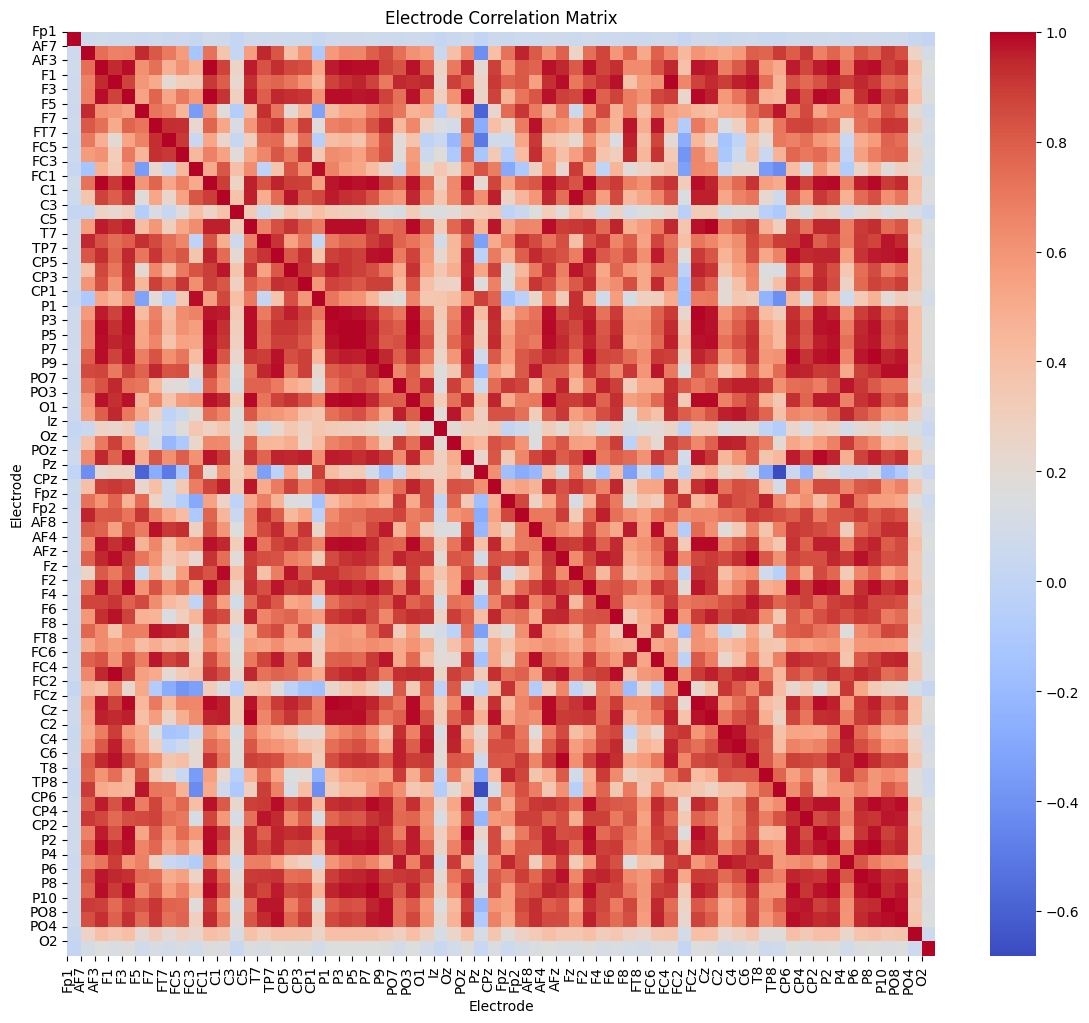

In [21]:
trials_dataset_period = trials_dataset[:, :, 25:50]
data_without_nan = np.nan_to_num(trials_dataset_period, nan=0)
data_reshaped = data_without_nan.reshape(data_without_nan.shape[0], -1)
corr_matrix = np.corrcoef(data_reshaped)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Electrode Correlation Matrix')
plt.xlabel('Electrode')
plt.ylabel('Electrode')
plt.xticks(ticks=np.arange(0, electrodes_num, 1), labels=electrodes_names, rotation=90)
plt.yticks(ticks=np.arange(0, electrodes_num, 1), labels=electrodes_names)
plt.show()

In [22]:
def identify_electrode_clusters(corr_matrix, n_clusters=8):
    """Group electrodes into clusters based on correlation."""
    if hasattr(corr_matrix, "filled"):
        corr_matrix = corr_matrix.filled(0)

    dist_matrix = 1 - np.abs(corr_matrix)
    Z = linkage(dist_matrix[np.triu_indices(dist_matrix.shape[0], k=1)], "ward")
    clusters = AgglomerativeClustering(n_clusters=n_clusters, metric="precomputed", linkage="average").fit_predict(dist_matrix)

    return clusters, Z


electrode_clusters, linkage_matrix = identify_electrode_clusters(corr_matrix)

for cluster_id in range(max(electrode_clusters) + 1):
    cluster_electrodes = np.where(electrode_clusters == cluster_id)[0]
    print(f"Cluster {cluster_id+1}: {len(cluster_electrodes)} electrodes")
    electrode_names_list = [electrodes_names[idx] for idx in sorted(cluster_electrodes)]
    print(f"  Electrodes: {electrode_names_list}")

Cluster 1: 55 electrodes
  Electrodes: ['AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC1', 'C1', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8']
Cluster 2: 3 electrodes
  Electrodes: ['FC3', 'CP1', 'Pz']
Cluster 3: 1 electrodes
  Electrodes: ['O2']
Cluster 4: 1 electrodes
  Electrodes: ['FT8']
Cluster 5: 1 electrodes
  Electrodes: ['Iz']
Cluster 6: 1 electrodes
  Electrodes: ['PO4']
Cluster 7: 1 electrodes
  Electrodes: ['C3']
Cluster 8: 1 electrodes
  Electrodes: ['Fp1']


#### Highly correlated electrodes: find redundant pairs

In [11]:
threshold = 0.90
highly_correlated_pairs = []
for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        if abs(corr_matrix[i, j]) > threshold:
            highly_correlated_pairs.append((electrodes_names[i], electrodes_names[j], corr_matrix[i, j]))

if highly_correlated_pairs:
    print(f"\nHighly correlated pairs (threshold > {threshold}):")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")


Highly correlated pairs (threshold > 0.9):
F1 - FC1: 0.91
F1 - Fz: 0.92
FC3 - FC1: 0.91
FC1 - C1: 0.93
FC1 - Fz: 0.92
FC1 - FC2: 0.92
FC1 - FCz: 0.95
FC1 - Cz: 0.90
C1 - CP1: 0.92
C1 - CPz: 0.92
C1 - FCz: 0.93
C1 - Cz: 0.95
C1 - C2: 0.92
CP3 - CP1: 0.91
CP3 - P3: 0.90
CP1 - CPz: 0.94
CP1 - Cz: 0.91
P1 - P3: 0.91
P1 - Pz: 0.92
P1 - P2: 0.91
P3 - P5: 0.91
P3 - PO3: 0.92
Pz - CPz: 0.92
Pz - P2: 0.94
CPz - Cz: 0.94
CPz - C2: 0.93
CPz - P2: 0.90
AFz - Fz: 0.91
Fz - F2: 0.94
Fz - FC2: 0.92
Fz - FCz: 0.93
F2 - FC2: 0.93
F2 - FCz: 0.92
FC2 - FCz: 0.96
FC2 - Cz: 0.92
FC2 - C2: 0.93
FCz - Cz: 0.94
FCz - C2: 0.92
Cz - C2: 0.95
C2 - C4: 0.91
CP4 - P2: 0.93
CP4 - P4: 0.93
P2 - P4: 0.94


### Identifying Most Active Electrodes


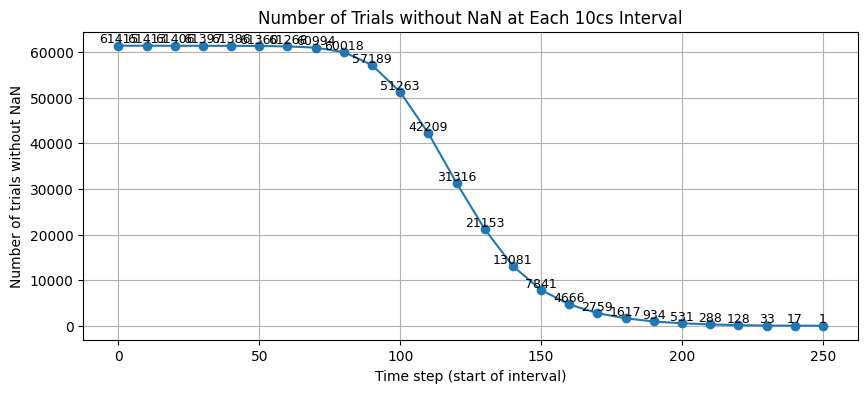

In [23]:
# Count number of trials without NaN at every 10cs interval and annotate numbers
interval = 10
n_time = trials_dataset.shape[2]
time_points = np.arange(0, n_time, interval)
n_trials_without_nan_per_interval = []

for start in time_points:
    end = min(start + interval, n_time)
    interval_nan = np.isnan(trials_dataset[:, :, start:end])
    trial_has_nan = np.any(interval_nan, axis=(0, 2))
    n_without_nan = np.sum(~trial_has_nan)
    n_trials_without_nan_per_interval.append(n_without_nan)

plt.figure(figsize=(10, 4))
plt.plot(time_points, n_trials_without_nan_per_interval, marker='o')
for x, y in zip(time_points, n_trials_without_nan_per_interval):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=9)
plt.xlabel('Time step (start of interval)')
plt.ylabel('Number of trials without NaN')
plt.title('Number of Trials without NaN at Each 10cs Interval')
plt.grid()
plt.show()

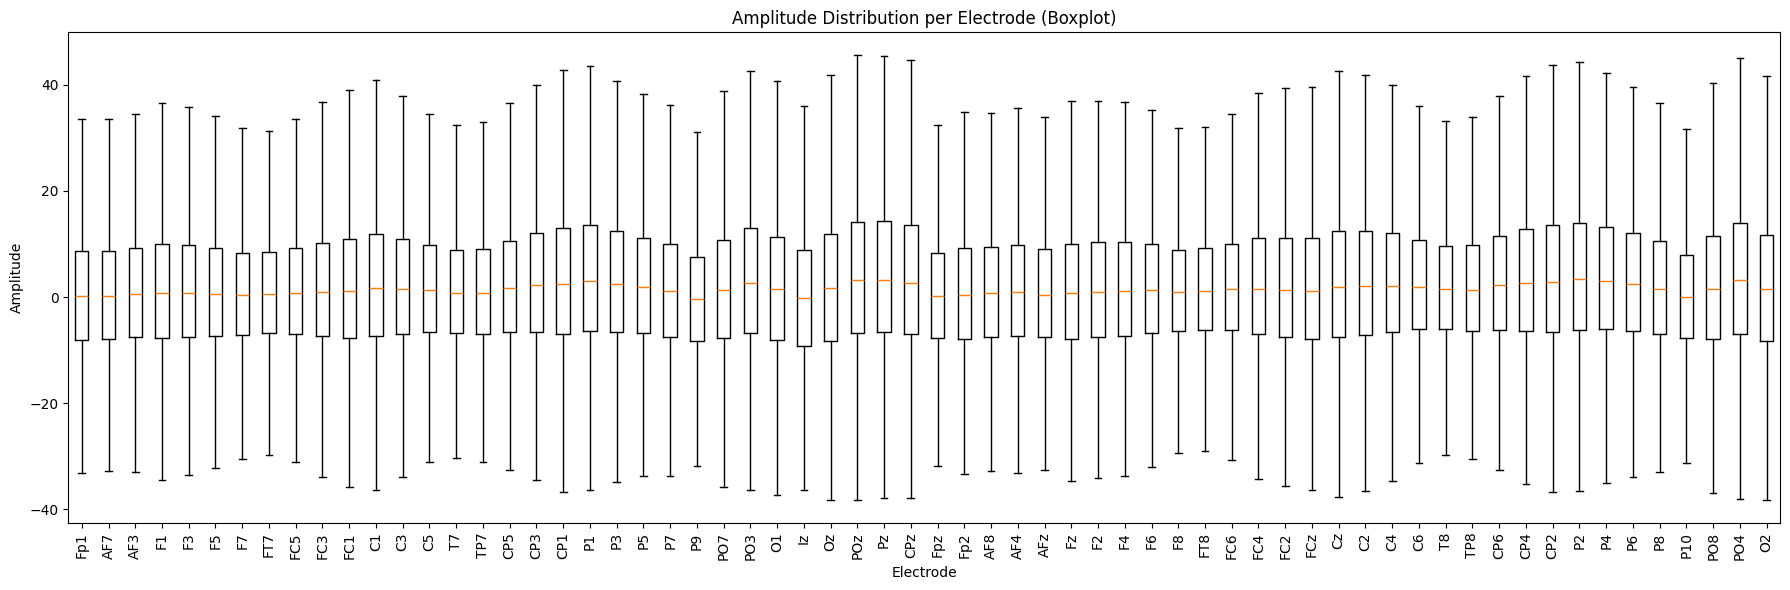

In [24]:
data_flat = trials_dataset.reshape(trials_dataset.shape[0], -1)
data_flat = np.where(np.isnan(data_flat), np.nan, data_flat)

plt.figure(figsize=(18, 6))
plt.boxplot([data_flat[i][~np.isnan(data_flat[i])] for i in range(data_flat.shape[0])],
            labels=electrodes_names, showfliers=False)
plt.xticks(rotation=90)
plt.xlabel("Electrode")
plt.ylabel("Amplitude") # what unit?
plt.title("Amplitude Distribution per Electrode (Boxplot)")
plt.tight_layout()
plt.show()


In [14]:
# Compute max and min amplitude for each electrode across all trials and time points
max_amplitude = np.nanmax(trials_dataset, axis=(1, 2))
min_amplitude = np.nanmin(trials_dataset, axis=(1, 2))

for i, name in enumerate(electrodes_names):
    print(f"{name}: min={min_amplitude[i]:.3f}, max={max_amplitude[i]:.3f}")

Fp1: min=-119.022, max=175.129
AF7: min=-150.901, max=133.863
AF3: min=-97.253, max=75.677
F1: min=-74.337, max=74.105
F3: min=-73.086, max=76.910
F5: min=-77.369, max=180.946
F7: min=-101.006, max=126.557
FT7: min=-83.573, max=131.596
FC5: min=-95.528, max=117.076
FC3: min=-63.885, max=80.929
FC1: min=-68.762, max=77.772
C1: min=-58.506, max=76.992
C3: min=-185.715, max=234.790
C5: min=-58.566, max=82.767
T7: min=-68.650, max=123.862
TP7: min=-112.524, max=120.104
CP5: min=-64.372, max=151.827
CP3: min=-63.902, max=88.471
CP1: min=-57.526, max=69.440
P1: min=-97.449, max=73.977
P3: min=-56.460, max=66.406
P5: min=-102.222, max=153.110
P7: min=-107.964, max=160.971
P9: min=-204.952, max=66.142
PO7: min=-97.145, max=111.698
PO3: min=-57.029, max=65.770
O1: min=-63.843, max=68.459
Iz: min=-183.628, max=129.751
Oz: min=-128.479, max=67.521
POz: min=-68.355, max=67.826
Pz: min=-54.830, max=77.058
CPz: min=-54.279, max=81.691
Fpz: min=-88.096, max=117.162
Fp2: min=-105.458, max=127.435
AF8:

In [15]:
def find_active_electrodes(trials_dataset, time_window=slice(30, 70)):
    """Identify the most active electrodes across all trials."""
    data = trials_dataset[:, :, time_window]
    avg_activity = np.nanmean(np.nanmean(np.abs(data), axis=2), axis=1)
    sorted_indices = np.argsort(-avg_activity)

    return sorted_indices, avg_activity


sorted_electrodes, activity_values = find_active_electrodes(trials_dataset)
print("Top 10 most active electrodes:")
for i, electrode in enumerate(sorted_electrodes[:10]):
    print(f"  Electrode {electrodes_names[electrode]}: Activity = {activity_values[electrode]:.4f}")

Top 10 most active electrodes:
  Electrode Iz: Activity = 13.7203
  Electrode Oz: Activity = 13.3895
  Electrode PO4: Activity = 13.2127
  Electrode O2: Activity = 13.0385
  Electrode O1: Activity = 12.6351
  Electrode POz: Activity = 12.2538
  Electrode Fp1: Activity = 12.2043
  Electrode PO3: Activity = 11.7937
  Electrode PO7: Activity = 11.7316
  Electrode PO8: Activity = 11.6392


### Electrodes Grouping and Periods

In [16]:
def create_electrode_groups(electrodes_names, method="correlation", electrode_clusters=None):
    """
    Create meaningful electrode groups using different methods.

    Args:
        electrodes_names: Array of electrode names
        method: Method to create groups ('correlation' or 'anatomical')
        electrode_clusters: Clustering result from correlation method (if applicable)

    Returns:
        electrode_groups: Dict with group names as keys and electrode indices as values
    """
    if method == "correlation":
        electrode_groups = {}
        for cluster_id in range(max(electrode_clusters) + 1):
            cluster_electrodes = np.where(electrode_clusters == cluster_id)[0]
            group_name = f"Group {cluster_id + 1}"
            electrode_groups[group_name] = np.array(cluster_electrodes)

    if method == "anatomical":
        patterns = {
            "frontal": re.compile(r"^(Fp|AF|F)\d*[a-zA-Z]*$", re.IGNORECASE),
            "temporal": re.compile(r"^(T|TP|FT)\d*[a-zA-Z]*$", re.IGNORECASE),
            "parietal": re.compile(r"^(P|CP)\d*[a-zA-Z]*$", re.IGNORECASE),
            "occipital": re.compile(r"^(O|PO)\d*[a-zA-Z]*$", re.IGNORECASE),
            "central": re.compile(r"^(C|FC)\d*[a-zA-Z]*$", re.IGNORECASE),
        }

        electrode_groups = {
            "frontal": [],
            "temporal": [],
            "parietal": [],
            "occipital": [],
            "central": [],
        }

        for region, pattern in patterns.items():
            matches = [i for i, name in enumerate(electrodes_names) if pattern.match(name)]
            electrode_groups[region] = matches

    if method == "custom":
        name_to_idx = {name: idx for idx, name in enumerate(electrodes_names)}
        electrode_groups = {
            region: [name_to_idx[name] for name in names if name in name_to_idx]
            for region, names in electrode_clusters.items()
        }

    return electrode_groups


electrode_groups = create_electrode_groups(electrodes_names, method="custom", electrode_clusters=default_clusters)
print("Electrode groups created based on custom regions:")
for group_name, indices in electrode_groups.items():
    print(f"{group_name}: {len(indices)} electrodes - {', '.join(electrodes_names[indices])}")


Electrode groups created based on custom regions:
frontal: 17 electrodes - Fp1, Fp2, Fpz, AF7, AF8, AF3, AF4, AFz, F1, F2, F3, F4, F5, F6, F7, F8, Fz
frontal-central: 7 electrodes - FC1, FC2, FC3, FC4, FC5, FC6, FCz
central: 14 electrodes - C1, C2, C3, C4, C5, C6, Cz, CP1, CP2, CP3, CP4, CP5, CP6, CPz
parietal-occipital: 20 electrodes - P1, P2, P3, P4, P5, P6, P7, P8, P9, P10, Pz, PO3, PO4, PO7, PO8, POz, O1, O2, Oz, Iz
temporal: 6 electrodes - TP7, TP8, T7, T8, FT7, FT8


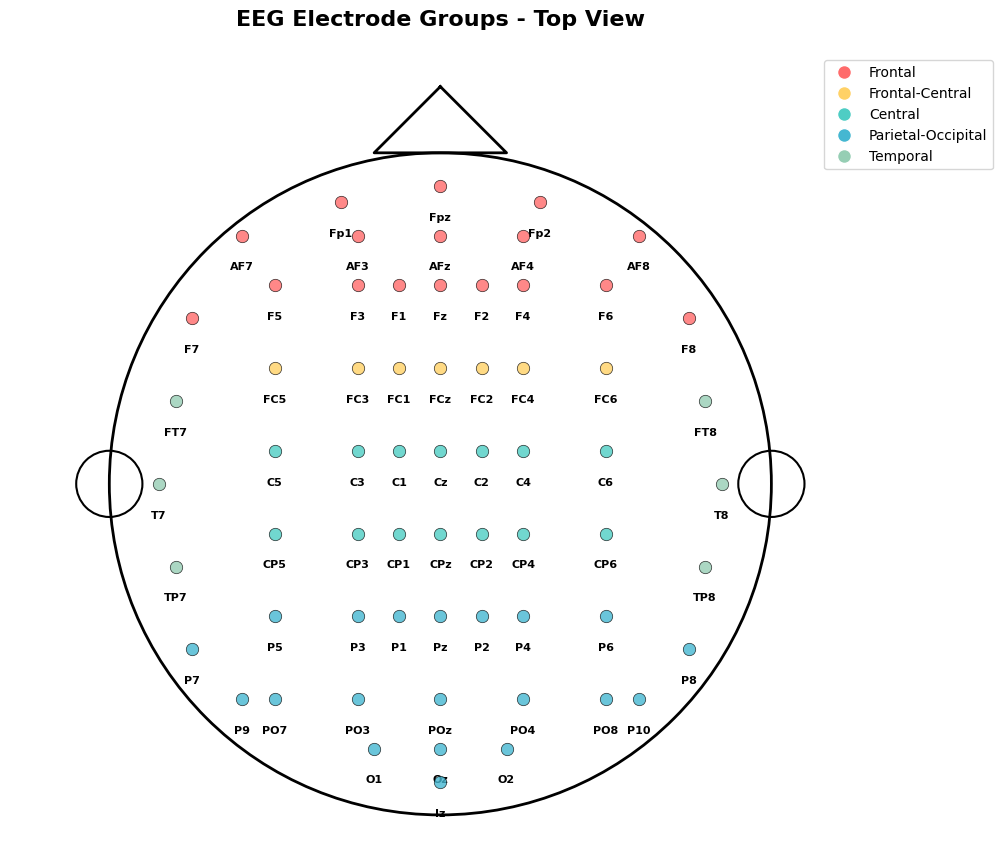

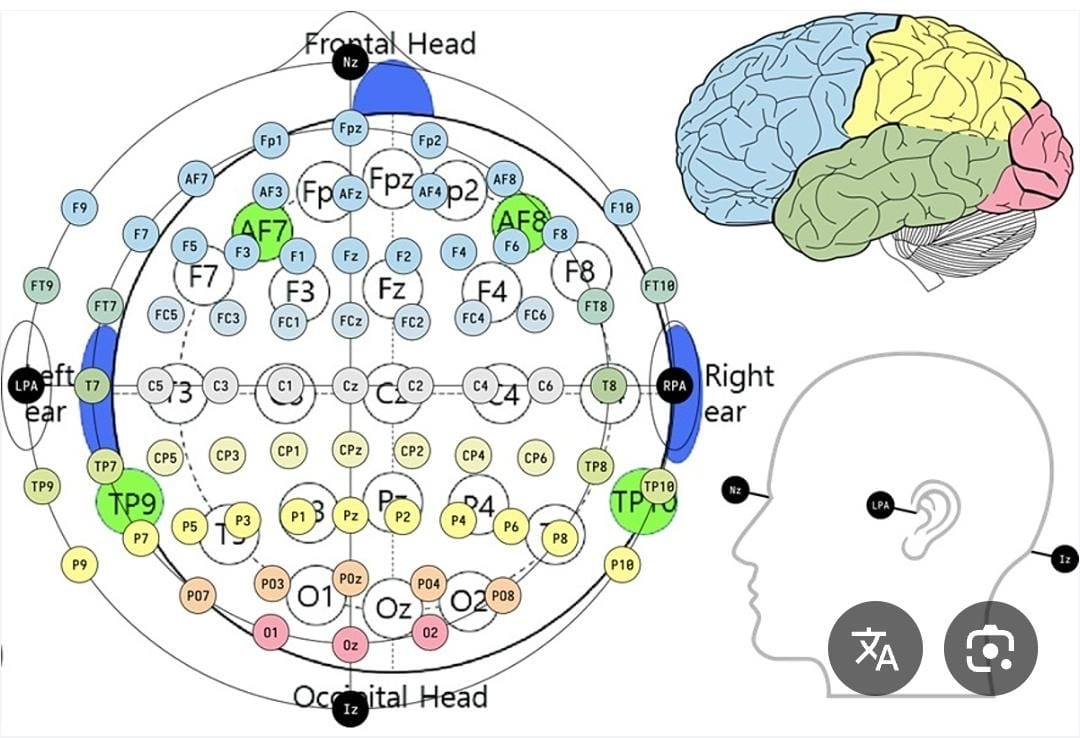

In [17]:
# Approximate electrode positions (normalized coordinates)
electrode_pos = {
    # Frontal row
    "Fp1": (-0.3, 0.85),
    "Fpz": (0, 0.9),
    "Fp2": (0.3, 0.85),
    "AF7": (-0.6, 0.75),
    "AF3": (-0.25, 0.75),
    "AFz": (0, 0.75),
    "AF4": (0.25, 0.75),
    "AF8": (0.6, 0.75),
    # Frontal row 2
    "F7": (-0.75, 0.5),
    "F5": (-0.5, 0.6),
    "F3": (-0.25, 0.6),
    "F1": (-0.125, 0.6),
    "Fz": (0, 0.6),
    "F2": (0.125, 0.6),
    "F4": (0.25, 0.6),
    "F6": (0.5, 0.6),
    "F8": (0.75, 0.5),
    # Fronto-central
    "FT7": (-0.8, 0.25),
    "FC5": (-0.5, 0.35),
    "FC3": (-0.25, 0.35),
    "FC1": (-0.125, 0.35),
    "FCz": (0, 0.35),
    "FC2": (0.125, 0.35),
    "FC4": (0.25, 0.35),
    "FC6": (0.5, 0.35),
    "FT8": (0.8, 0.25),
    # Central
    "T7": (-0.85, 0),
    "C5": (-0.5, 0.1),
    "C3": (-0.25, 0.1),
    "C1": (-0.125, 0.1),
    "Cz": (0, 0.1),
    "C2": (0.125, 0.1),
    "C4": (0.25, 0.1),
    "C6": (0.5, 0.1),
    "T8": (0.85, 0),
    # Centro-parietal
    "TP7": (-0.8, -0.25),
    "CP5": (-0.5, -0.15),
    "CP3": (-0.25, -0.15),
    "CP1": (-0.125, -0.15),
    "CPz": (0, -0.15),
    "CP2": (0.125, -0.15),
    "CP4": (0.25, -0.15),
    "CP6": (0.5, -0.15),
    "TP8": (0.8, -0.25),
    # Parietal
    "P7": (-0.75, -0.5),
    "P5": (-0.5, -0.4),
    "P3": (-0.25, -0.4),
    "P1": (-0.125, -0.4),
    "Pz": (0, -0.4),
    "P2": (0.125, -0.4),
    "P4": (0.25, -0.4),
    "P6": (0.5, -0.4),
    "P8": (0.75, -0.5),
    "P9": (-0.6, -0.65),
    "P10": (0.6, -0.65),
    # Occipital
    "PO7": (-0.5, -0.65),
    "PO3": (-0.25, -0.65),
    "POz": (0, -0.65),
    "PO4": (0.25, -0.65),
    "PO8": (0.5, -0.65),
    "O1": (-0.2, -0.8),
    "Oz": (0, -0.8),
    "O2": (0.2, -0.8),
    "Iz": (0, -0.9),
}

# Colors for each group
colors = {
    "frontal": "#FF6B6B",
    "frontal-central": "#FFD166",
    "central": "#4ECDC4",
    "parietal-occipital": "#45B7D1",
    "temporal": "#96CEB4"
}

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Draw head outline
head = Circle((0, 0), 1, fill=False, linewidth=2, color="black")
ax.add_patch(head)

# Draw nose
nose_x = [0, -0.2, 0.2, 0]
nose_y = [1.2, 1, 1, 1.2]
ax.plot(nose_x, nose_y, "k-", linewidth=2)

# Draw ears
ear_left = Circle((-1, 0), 0.1, fill=False, linewidth=1.5, color="black")
ear_right = Circle((1, 0), 0.1, fill=False, linewidth=1.5, color="black")
ax.add_patch(ear_left)
ax.add_patch(ear_right)

# Plot electrodes by group
for group_name, electrodes in default_clusters.items():
    for electrode in electrodes:
        if electrode in electrode_pos:
            x, y = electrode_pos[electrode]
            ax.scatter(x, y, c=colors[group_name], s=80, alpha=0.8, edgecolors="black", linewidth=0.5, zorder=10)
            ax.text(x, y - 0.08, electrode, ha="center", va="top", fontsize=8, fontweight="bold")

# Create legend
legend_elements = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[group], markersize=10, label=group.replace("_", "-").title())
    for group in default_clusters.keys()
]

ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.15, 1))

# Set equal aspect ratio and limits
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.1, 1.3)
ax.set_aspect("equal")
ax.axis("off")

plt.title("EEG Electrode Groups - Top View", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

from IPython.display import Image, display

display(Image(filename="eeg_electrodes_map.JPG"))

### Electrode Activity Analysis By Trial Type

In [18]:
def plot_electrode_avg(data, first_mask, second_mask, legend_labels, time_window=slice(20, 60), electrode_groups=None):
    """
    Plot the average of the data for two different conditions within a specified time window.
    If electrode_groups is provided, plot each group as a subplot in a single figure.

    Args:
        data (numpy.ndarray): The EEG data of shape (n_electrodes, n_trials, n_time).
        first_mask (numpy.ndarray): Boolean mask for the first condition.
        second_mask (numpy.ndarray): Boolean mask for the second condition.
        legend_labels (list): Labels for the two conditions to be plotted.
        time_window (slice): Time window to plot (default is slice(20, 85)).
        electrode_groups (dict): Dictionary of electrode groups with group names as keys and indices as values
    """

    avg_first = np.nanmean(data[:, first_mask, :], axis=1)
    avg_second = np.nanmean(data[:, second_mask, :], axis=1)

    time_vector = np.arange(data.shape[2])[time_window]
    if electrode_groups is None:
        electrode_groups = {"All Electrodes": np.arange(data.shape[0])}

    n_groups = len(electrode_groups)
    fig, axes = plt.subplots(n_groups, 1, figsize=(12, 4 * n_groups))
    if n_groups == 1:
        axes = [axes]
    for ax, (group_name, indices) in zip(axes, electrode_groups.items()):
        for i in indices:
            ax.plot(time_vector, avg_first[i][time_window], alpha=0.3, color="blue")
            ax.plot(time_vector, avg_second[i][time_window], alpha=0.3, color="red")
        ax.set_ylabel("Amplitude")
        ax.set_xlabel("Time (cs)")
        ax.set_title(
            f"{group_name}: Average EEG Signal for {legend_labels[0]} and {legend_labels[1]} (Time {time_window.start}-{time_window.stop} cs)"
        )
        ax.grid()
        ax.legend(legend_labels)
    plt.tight_layout()
    plt.show()


def mean_electrode_by_period(avg_first, avg_second, legend_labels, periods, normalize=True):
    """
    Plot the mean activity of electrodes in different time periods, with optional normalization.
    All periods are shown as subplots in a single (vertical) figure.

    Args:
        avg_first (numpy.ndarray): Average data for the first condition (electrodes x time).
        avg_second (numpy.ndarray): Average data for the second condition (electrodes x time).
        legend_labels (list): Labels for the two conditions to be plotted.
        periods (dict): Dictionary with period names as keys and (start, end) tuples as values.
        normalize (bool): Whether to normalize the data before plotting (default is True).
    """
    n_periods = len(periods)
    fig, axes = plt.subplots(n_periods, 1, figsize=(12, 4 * n_periods))
    if n_periods == 1:
        axes = [axes]
    for ax, (period, (start, end)) in zip(axes, periods.items()):
        mean_cong = np.nanmean(avg_first[:, start:end], axis=1)
        mean_incong = np.nanmean(avg_second[:, start:end], axis=1)
        if normalize:
            all_vals = np.concatenate([mean_cong, mean_incong])
            min_val, max_val = np.nanmin(all_vals), np.nanmax(all_vals)
            if max_val > min_val:
                mean_cong = (mean_cong - min_val) / (max_val - min_val)
                mean_incong = (mean_incong - min_val) / (max_val - min_val)
        ax.bar(np.arange(len(mean_cong)) - 0.2, mean_cong, width=0.4, color="blue", alpha=0.7, label=legend_labels[0])
        ax.bar(np.arange(len(mean_incong)) + 0.2, mean_incong, width=0.4, color="red", alpha=0.7, label=legend_labels[1])
        ax.set_title(f"{period} Period")
        ax.set_ylabel("Normalized Mean Amplitude" if normalize else "Mean Amplitude (a.u.)")
        ax.set_xlabel("Electrode")
        ax.set_xticks(np.arange(len(mean_cong)))
        ax.set_xticklabels(electrodes_names, rotation=90)
        ax.legend()
    plt.tight_layout()
    plt.show()


def plot_electrode_corr_difference(data, mask_first, mask_second, legend_labels):
    """
    Plot the difference in correlation between two conditions.
    """
    cong = data[:, mask_first, 20:40].reshape(data.shape[0], -1)
    incong = data[:, mask_second, 20:40].reshape(data.shape[0], -1)
    corr_mat = np.corrcoef(cong) - np.corrcoef(incong)

    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_mat, cmap="coolwarm")
    plt.title(f"Difference in Correlation Matrices: {legend_labels[0]} - {legend_labels[1]}")
    plt.xticks(ticks=np.arange(0, 64, 1), labels=electrodes_names, rotation=90)
    plt.yticks(ticks=np.arange(0, 64, 1), labels=electrodes_names)
    plt.show()


def analyze_time_course(trials_dataset, category_indices, period=slice(35, 80), category_name="Category", window_size=10):
    """
    Analyze the time course of activity for a given category of trials.

    Args:
        trials_dataset (np.ndarray): EEG data of shape (n_electrodes, n_trials, n_time).
        category_indices (array-like): Indices for the category trials (boolean mask or indices).
        time_window (slice): Time window to analyze
        category_name (str): Name of the category
        window_size (int): Size of the window for most active window search.

    Returns:
        gfp (np.ndarray): Global field power (std across electrodes) for the time window.
        peak_time (int): Index of peak activity within the time window.
        peak_window_start (int): Index of the most active window start within the time window.
    """
    cat_data = trials_dataset[:, category_indices, period]
    avg_data = np.nanmean(cat_data, axis=1)
    gfp = np.nanstd(avg_data, axis=0)
    peak_time = np.nanargmax(gfp)
    if len(gfp) > window_size:
        window_avg = np.array([np.nanmean(gfp[i : i + window_size]) for i in range(len(gfp) - window_size)])
        peak_window_start = np.argmax(window_avg)
    else:
        peak_window_start = 0
    return gfp, peak_time, peak_window_start


def analyze_category_differences(trials_dataset, category_indices1, category_indices2, periods=None, category_names=("A", "B")):
    """
    Analyze differences between two categories of trials for multiple periods.

    Args:
        trials_dataset (numpy.ndarray): EEG data of shape (n_electrodes, n_trials, n_time).
        category_indices1 (array-like): Indices for category 1 trials.
        category_indices2 (array-like): Indices for category 2 trials.
        periods (dict): Dictionary of period names to (start, end) tuples.
        category_names (tuple): Names for the two categories.

    Returns:
        results (dict): Dictionary with period as key and (cat1_avg, cat2_avg, diff, p_values) as value.
    """
    if periods is None:
        periods = {"Pre": (0, 20), "Early": (20, 40), "Middle": (40, 70), "Late": (70, 103)}

    results = {}
    for period, (start, end) in periods.items():
        cat1_data = trials_dataset[:, category_indices1, start:end]
        cat2_data = trials_dataset[:, category_indices2, start:end]
        cat1_avg = np.nanmean(cat1_data, axis=1)
        cat2_avg = np.nanmean(cat2_data, axis=1)
        diff = cat1_avg - cat2_avg

        p_values = []
        for electrode in range(trials_dataset.shape[0]):
            data1 = cat1_avg[electrode]
            data2 = cat2_avg[electrode]
            valid_indices = ~(np.isnan(data1) | np.isnan(data2))
            if np.sum(valid_indices) > 10:
                t, p = stats.ttest_ind(data1[valid_indices], data2[valid_indices], equal_var=False)
                p_values.append((electrode, p))
        p_values.sort(key=lambda x: x[1])
        results[period] = (cat1_avg, cat2_avg, diff, p_values)

    for period, (cat1_avg, cat2_avg, diff, p_values) in results.items():
        print(f"\n{period} Period:")
        print(f"  Right Avg: {np.nanmean(cat1_avg):.4f}, Left Avg: {np.nanmean(cat2_avg):.4f}")
        print(f"  Difference: {np.nanmean(diff):.4f}")
        print(f"  Top 5 Electrodes with Lowest p-values:")
        for electrode, p in p_values[:5]:
            print(f"    Electrode {electrodes_names[electrode]}: p-value = {p:.4e}")


def print_electrode_differences(avg_first, avg_second, electrodes_names, top_n=7, label1=None, label2=None):
    """
    Print electrodes with minimal and maximal mean differences between two conditions.
    Also prints electrodes with maximal activity in each condition.

    Args:
        avg_first (np.ndarray): Average data for first condition (electrodes x time).
        avg_second (np.ndarray): Average data for second condition (electrodes x time).
        electrodes_names (np.ndarray or list): Names of electrodes.
        top_n (int): Number of electrodes to print for each category.
        label1 (str): Name for first condition.
        label2 (str): Name for second condition.
    """
    mean_diff = np.abs(np.nanmean(avg_first, axis=1) - np.nanmean(avg_second, axis=1))
    sorted_diff_indices = np.argsort(mean_diff)

    print(f"\nElectrodes with minimal difference between {label1} and {label2} (All periods):")
    for i in range(top_n):
        idx = sorted_diff_indices[i]
        print(f"{electrodes_names[idx]}: {mean_diff[idx]:.4f}")

    print(f"\nElectrodes with maximal difference between {label1} and {label2} (All periods):")
    for i in range(top_n):
        idx = sorted_diff_indices[-(i + 1)]
        print(f"{electrodes_names[idx]}: {mean_diff[idx]:.4f}")

def response_locked_transform(mat):
    """
    Function to lock the EEG data to the time of the response.
    :param mat: EEG data matrix of shape (channels, trials, time)
    :return: Response-locked EEG data matrix of shape (channels, trials, time)
    """

    # Find the indices of the first NaN along the third dimension (sequence length)
    nan_mask = np.isnan(mat)  # Shape: (channels, batch_size, , sequence_length)
    nan_indices = np.argmax(nan_mask, axis=2)-1 # Shape: (channels, batch_size)

    # Create indices for the 30 values before the first NaN
    sequence_indices = np.arange(50).reshape(1, 1, -1)  # Shape: (1, 1, 30)
    nan_indices_expanded = nan_indices[..., np.newaxis]  # Shape: (channels, batch_size, 1)
    indices_to_extract = nan_indices_expanded - sequence_indices[:, :, ::-1]  # Shape: (channels, batch_size, 30)

    # Ensure indices are within bounds
    indices_to_extract = np.clip(indices_to_extract, 0, mat.shape[2] - 1)

    # Use advanced indexing to extract the values
    channels = np.arange(mat.shape[0])[:, np.newaxis, np.newaxis]  # Shape: (channels, 1, 1)
    batches = np.arange(mat.shape[1])[np.newaxis, :, np.newaxis]  # Shape: (1, batch_size, 1)
    mat_response_locked = mat[channels, batches, indices_to_extract]  # Shape: (channels, batch_size, 30)
    return mat_response_locked

In [19]:
def plot_electrode_avg_interactive(data, first_mask, second_mask, legend_labels, 
                                  time_window_start=20, time_window_end=60, 
                                  electrode_groups_selection=None,
                                  trials_min_end=None, trials_max_end=None,
                                  response_locked=False):
    """
    Interactive version of plot_electrode_avg with additional trial filtering by length and response-locked option.
    
    Args:
        data (numpy.ndarray): The EEG data of shape (n_electrodes, n_trials, n_time).
        first_mask (numpy.ndarray): Boolean mask for the first condition.
        second_mask (numpy.ndarray): Boolean mask for the second condition.
        legend_labels (list): Labels for the two conditions to be plotted.
        time_window_start (int): Start of time window to plot.
        time_window_end (int): End of time window to plot.
        electrode_groups_selection (list): List of electrode group names to plot.
        trials_min_end (int): Minimum trial length (filter trials by last non-NaN timepoint).
        trials_max_end (int): Maximum trial length (filter trials by last non-NaN timepoint).
        response_locked (bool): Whether to show response-locked data (aligned to trial end).
    """

    # Filter trials by length if specified
    if trials_min_end is not None or trials_max_end is not None:
        # Vectorized trial length computation
        valid_mask = ~np.isnan(data)
        any_valid = np.any(valid_mask, axis=0)  # Shape: (n_trials, n_time)
        
        # Find last valid time for all trials at once
        any_valid_reversed = np.flip(any_valid, axis=1)
        has_valid = np.any(any_valid, axis=1)
        
        trial_lengths = np.full(data.shape[1], 0, dtype=int)
        if np.any(has_valid):
            first_valid_reversed = np.argmax(any_valid_reversed[has_valid], axis=1)
            trial_lengths[has_valid] = data.shape[2] - 1 - first_valid_reversed
        
        # Create length-based mask
        length_mask = np.ones(data.shape[1], dtype=bool)
        if trials_min_end is not None:
            length_mask &= (trial_lengths >= trials_min_end)
        if trials_max_end is not None:
            length_mask &= (trial_lengths <= trials_max_end)
        
        # Apply length mask to condition masks
        first_mask = first_mask & length_mask
        second_mask = second_mask & length_mask
        
        print(f"Filtered trials: {np.sum(first_mask)} first condition, {np.sum(second_mask)} second condition")
    
    # Create time window slice
    time_window = slice(time_window_start, time_window_end)
    time_vector = np.arange(data.shape[2])[time_window]
    
    # Adjust time vector labels for response-locked data
    if response_locked:
        # For response-locked data, time 0 is the response time
        time_vector = time_vector - (time_window_end - 1)  # Shift to make 0 at response time
        data = response_locked_transform(data)  # Transform data to response-locked

    # Calculate averages
    avg_first = np.nanmean(data[:, first_mask, :], axis=1)
    avg_second = np.nanmean(data[:, second_mask, :], axis=1)
    
    # Handle electrode groups selection
    if electrode_groups_selection is None:
        electrode_groups_to_plot = {"All Electrodes": np.arange(data.shape[0])}
    else:
        electrode_groups_to_plot = {}
        for group_name in electrode_groups_selection:
            if group_name in electrode_groups:
                electrode_groups_to_plot[group_name] = electrode_groups[group_name]
    
    # Create plots
    n_groups = len(electrode_groups_to_plot)
    fig, axes = plt.subplots(n_groups, 1, figsize=(12, 4 * n_groups))
    if n_groups == 1:
        axes = [axes]
    
    for ax, (group_name, indices) in zip(axes, electrode_groups_to_plot.items()):
        for i in indices:
            ax.plot(time_vector, avg_first[i][time_window], alpha=0.3, color="blue")
            ax.plot(time_vector, avg_second[i][time_window], alpha=0.3, color="red")
        ax.set_ylabel("Amplitude")
        if response_locked:
            ax.set_xlabel("Time before response (cs)")
            ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Response time')
        else:
            ax.set_xlabel("Time (cs)")

        lock_type = "Response-locked" if response_locked else "Stimulus-locked"
        ax.set_title(f"{group_name}: {legend_labels[0]} vs {legend_labels[1]} ({lock_type}, Time {time_window_start}-{time_window_end})")
        ax.grid()
        ax.legend(legend_labels)
    
    plt.tight_layout()
    plt.show()


# Create widgets that adjust based on response-locked mode
def create_interactive_widgets():
    """Create interactive widgets with dynamic parameter adjustment."""
    
    # Create widgets
    response_locked_widget = widgets.Checkbox(
        value=False,
        description='Response-locked',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    time_window_start_widget = widgets.IntSlider(
        min=0, max=103, step=1, value=20,
        description='Start Time:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    time_window_end_widget = widgets.IntSlider(
        min=0, max=103, step=1, value=60,
        description='End Time:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    electrode_groups_selection_widget = widgets.SelectMultiple(
        options=list(electrode_groups.keys()),
        value=['frontal', 'central'],
        description='Electrode Groups:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px', height='120px')
    )
    
    trials_min_end_widget = widgets.IntSlider(
        min=0, max=103, step=1, value=40,
        description='Min Trial Length:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    trials_max_end_widget = widgets.IntSlider(
        min=0, max=103, step=1, value=80,
        description='Max Trial Length:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    condition_type_widget = widgets.Dropdown(
        options=['Congruent vs Incongruent', 'Left vs Right', 'Free Choice vs Instruction'],
        value='Congruent vs Incongruent',
        description='Condition:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Function to update widget ranges based on response-locked mode
    def update_widget_ranges(change):        
        if response_locked_widget.value:
            # Response-locked mode: adjust to 50 time points
            time_window_start_widget.value = 0
            time_window_end_widget.value = 50
        else:
            # Stimulus-locked mode: restore original ranges
            time_window_start_widget.value = 20
            time_window_end_widget.value = 60

    # Create the interactive function
    def interactive_electrode_plot(time_window_start, time_window_end, electrode_groups_selection, 
                                  trials_min_end, trials_max_end, condition_type, response_locked):
        """Interactive wrapper for the electrode plotting function."""
        
        # Define conditions based on selection
        if condition_type == 'Congruent vs Incongruent':
            first_mask = (cues == primes) & (cues == true_labels)   # Congruent
            second_mask = (cues != primes) & (cues == true_labels)  # Incongruent
            legend_labels = ["Congruent", "Incongruent"]
        elif condition_type == 'Left vs Right':
            first_mask = true_labels == 2   # Left
            second_mask = true_labels == 1  # Right
            legend_labels = ["Left", "Right"]
        elif condition_type == 'Free Choice vs Instruction':
            first_mask = cues == 4  # Free choice
            second_mask = (true_labels == 1) | (true_labels == 2)  # Instruction
            legend_labels = ["Free Choice", "Instruction"]
        
        # Ensure time window is valid
        if time_window_start >= time_window_end:
            print("Error: Start time must be less than end time")
            return

        # Ensure time window is within bounds when response-locked
        if response_locked and (time_window_end > 50 or time_window_start > 0):
            print("Error: Response-locked time window must be 50 cs or less")
            return
        
        # Call the interactive plotting function
        plot_electrode_avg_interactive(
            trials_dataset, first_mask, second_mask, legend_labels,
            time_window_start, time_window_end,
            list(electrode_groups_selection),
            trials_min_end, trials_max_end,
            response_locked
        )
    
    # Create the interactive widget
    interactive_widget = widgets.interactive(
        interactive_electrode_plot,
        time_window_start=time_window_start_widget,
        time_window_end=time_window_end_widget,
        electrode_groups_selection=electrode_groups_selection_widget,
        trials_min_end=trials_min_end_widget,
        trials_max_end=trials_max_end_widget,
        condition_type=condition_type_widget,
        response_locked=response_locked_widget
    )
    
    # Connect the callback to the response-locked checkbox AFTER creating the interactive widget
    response_locked_widget.observe(update_widget_ranges, names='value')
    
    return interactive_widget

# Create and display the interactive widget
interactive_widget = create_interactive_widgets()
display(interactive_widget)

NameError: name 'widgets' is not defined

#### Congruent vs. Incongruent Trials

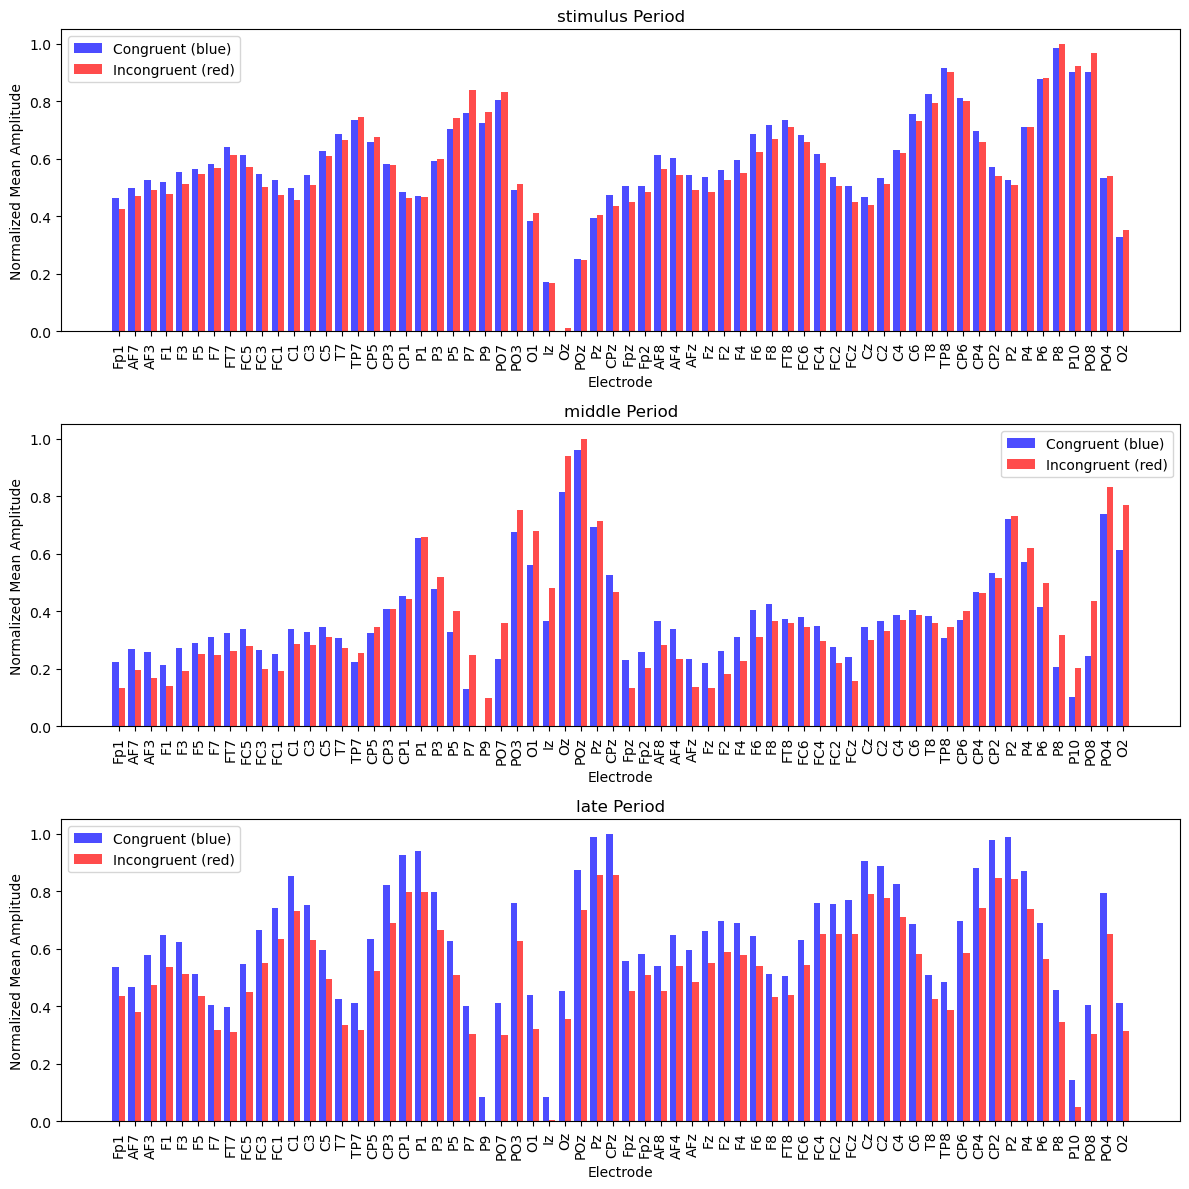

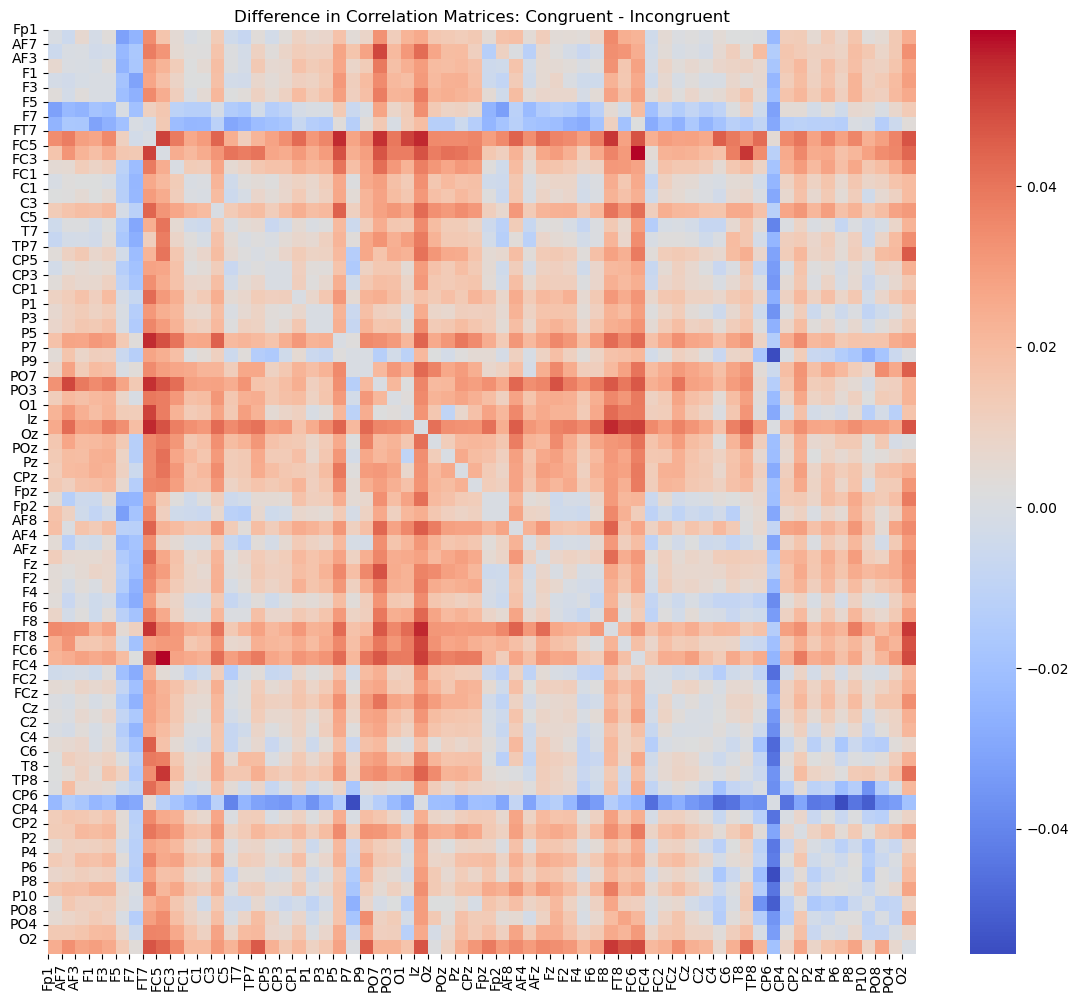

In [ ]:
congruent_mask = (cues == primes) & (cues == true_labels)
incongruent_mask = (cues != primes) & (cues == true_labels)
legend_labels = ["Congruent (blue)", "Incongruent (red)"]

avg_congruent = np.nanmean(trials_dataset[:, congruent_mask, :], axis=1)
avg_incongruent = np.nanmean(trials_dataset[:, incongruent_mask, :], axis=1)
mean_electrode_by_period(avg_congruent, avg_incongruent, legend_labels, default_periods)
plot_electrode_corr_difference(trials_dataset, congruent_mask, incongruent_mask, ["Congruent", "Incongruent"])

In [ ]:
print_electrode_differences(avg_congruent, avg_incongruent, electrodes_names, label1="Congruent", label2="Incongruent")
analyze_category_differences(trials_dataset, congruent_mask, incongruent_mask, periods=periods, category_names=("Congruent", "Incongruent"))


Electrodes with minimal difference between Congruent and Incongruent (All periods):
Iz: 0.0075
Pz: 0.0113
CP1: 0.0126
POz: 0.0233
P3: 0.0257
T7: 0.0334
T8: 0.0413

Electrodes with maximal difference between Congruent and Incongruent (All periods):
O1: 0.4944
F5: 0.4766
Fp2: 0.4664
AF8: 0.4545
Fp1: 0.4541
F3: 0.3884
F7: 0.3864

stimulus Period:
  Right Avg: -0.5420, Left Avg: -0.5949
  Difference: 0.0529
  Top 5 Electrodes with Lowest p-values:
    Electrode CPz: p-value = 4.4092e-01
    Electrode FC5: p-value = 4.6771e-01
    Electrode Fpz: p-value = 4.7340e-01
    Electrode FC3: p-value = 4.8487e-01
    Electrode C1: p-value = 4.9250e-01

middle Period:
  Right Avg: -0.8959, Left Avg: -0.9226
  Difference: 0.0267
  Top 5 Electrodes with Lowest p-values:
    Electrode F3: p-value = 5.4449e-02
    Electrode AF4: p-value = 6.1893e-02
    Electrode Fp1: p-value = 6.3871e-02
    Electrode AF3: p-value = 6.5813e-02
    Electrode FCz: p-value = 6.6533e-02

late Period:
  Right Avg: 6.4787, 

#### Left vs. Right

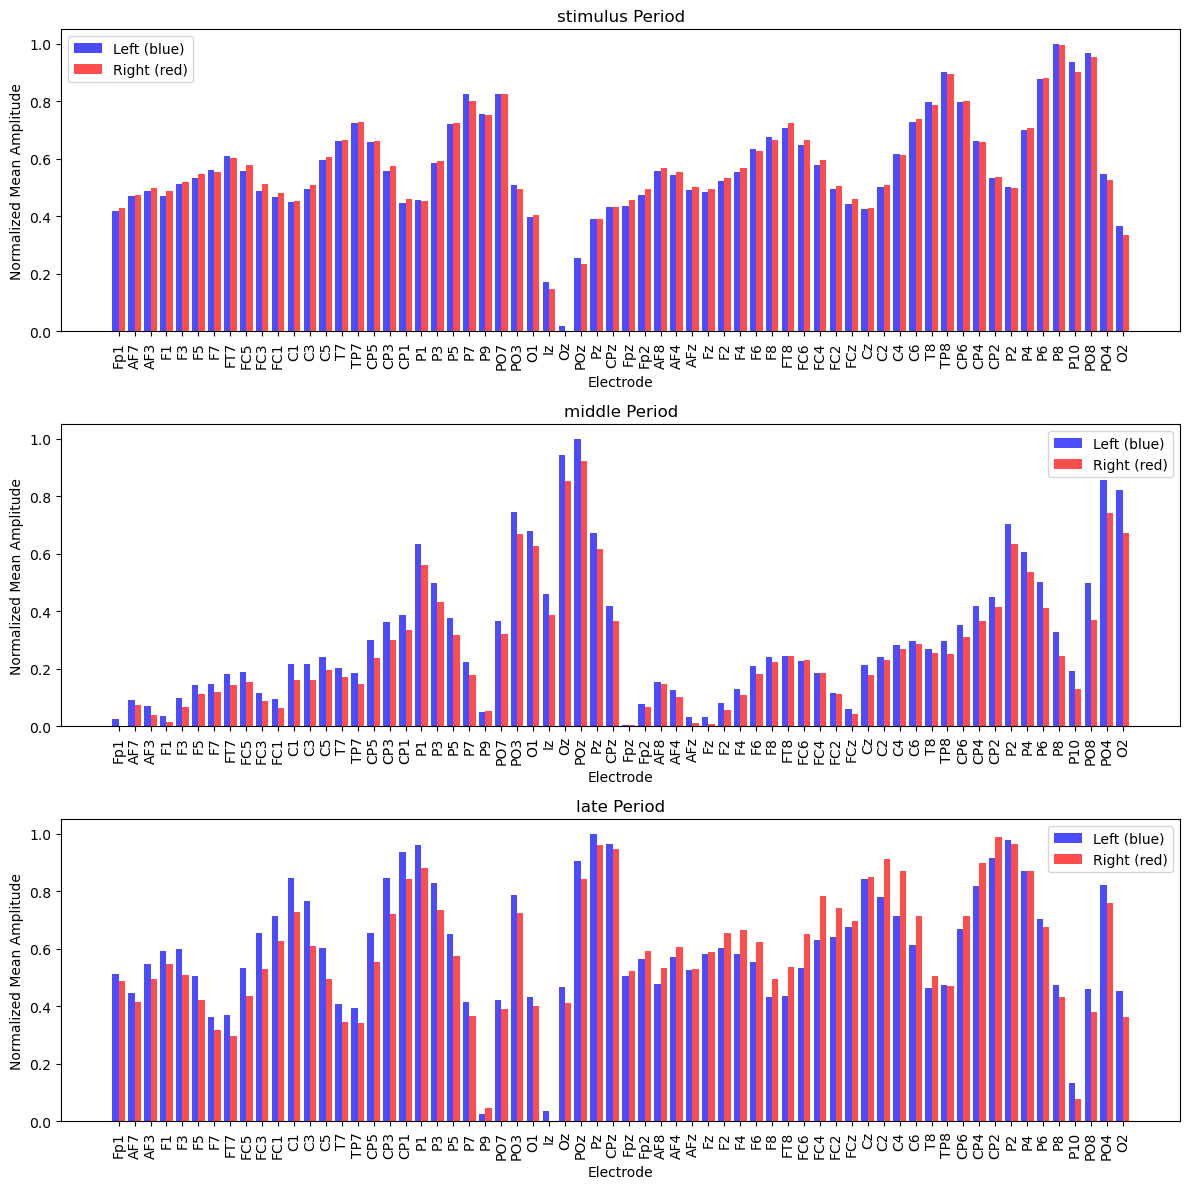

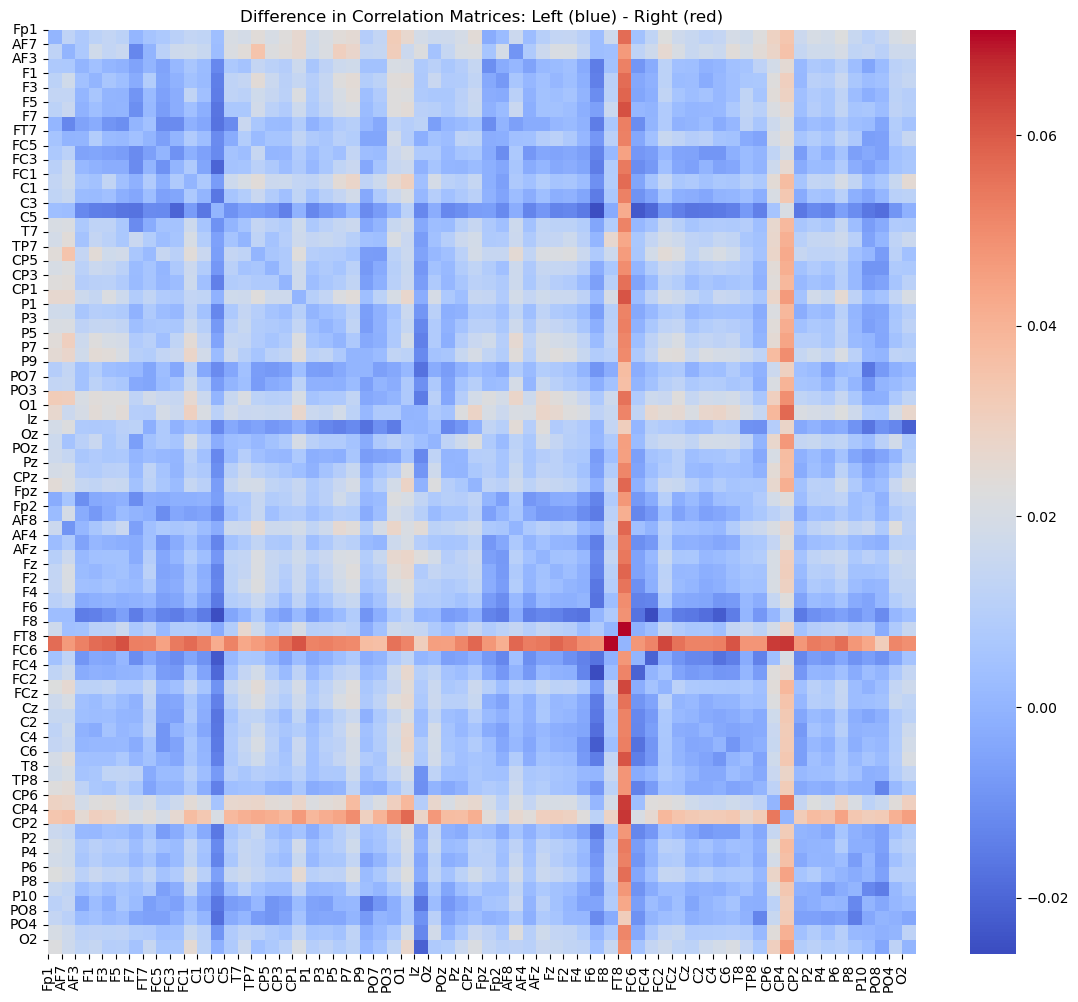

In [ ]:
left_mask = true_labels == 2  # 'L' = 2
right_mask = true_labels == 1  # 'R' = 1
legend_labels = ["Left (blue)", "Right (red)"]

avg_left = np.nanmean(trials_dataset[:, left_mask, :], axis=1)
avg_right = np.nanmean(trials_dataset[:, right_mask, :], axis=1)
mean_electrode_by_period(avg_left, avg_right, legend_labels, default_periods)
plot_electrode_corr_difference(trials_dataset, left_mask, right_mask, legend_labels)

In [ ]:
print_electrode_differences(avg_left, avg_right, electrodes_names, label1="Left", label2="Right")
analyze_category_differences(trials_dataset, right_mask, left_mask, periods=periods, category_names=("Right", "Left"))


Electrodes with minimal difference between Left and Right (All periods):
P2: 0.0140
Fpz: 0.0181
O1: 0.0283
AFz: 0.0295
TP7: 0.0353
P7: 0.0394
CP6: 0.0587

Electrodes with maximal difference between Left and Right (All periods):
FC4: 1.1909
C4: 0.9291
FC6: 0.9136
F4: 0.8844
FC2: 0.8367
C3: 0.8100
C2: 0.8026

stimulus Period:
  Right Avg: -0.6602, Left Avg: -0.6677
  Difference: 0.0075
  Top 5 Electrodes with Lowest p-values:
    Electrode FC3: p-value = 7.0340e-01
    Electrode FC5: p-value = 7.0343e-01
    Electrode CP3: p-value = 7.9599e-01
    Electrode CP1: p-value = 7.9883e-01
    Electrode Fpz: p-value = 8.0792e-01

middle Period:
  Right Avg: -0.9090, Left Avg: -0.6938
  Difference: -0.2152
  Top 5 Electrodes with Lowest p-values:
    Electrode FT7: p-value = 2.7892e-01
    Electrode C1: p-value = 3.2657e-01
    Electrode F3: p-value = 3.8009e-01
    Electrode C3: p-value = 3.9311e-01
    Electrode FC5: p-value = 3.9870e-01

late Period:
  Right Avg: 5.2038, Left Avg: 5.3554
  D

In [ ]:
right_gfp, right_peak, right_window = analyze_time_course(trials_dataset, right_mask, category_name="Right")
left_gfp, left_peak, left_window = analyze_time_course(trials_dataset, left_mask, category_name="Left")

print(f"Right trials - Peak activity at: {right_peak} cs")
print(f"Left trials - Peak activity at: {left_peak} cs")
print(f"Right trials - Most active window starts at: {right_window} cs")
print(f"Left trials - Most active window starts at: {left_window} cs")

Right trials - Peak activity at: 24 cs
Left trials - Peak activity at: 24 cs
Right trials - Most active window starts at: 20 cs
Left trials - Most active window starts at: 20 cs


#### Free Choice vs. Instruction

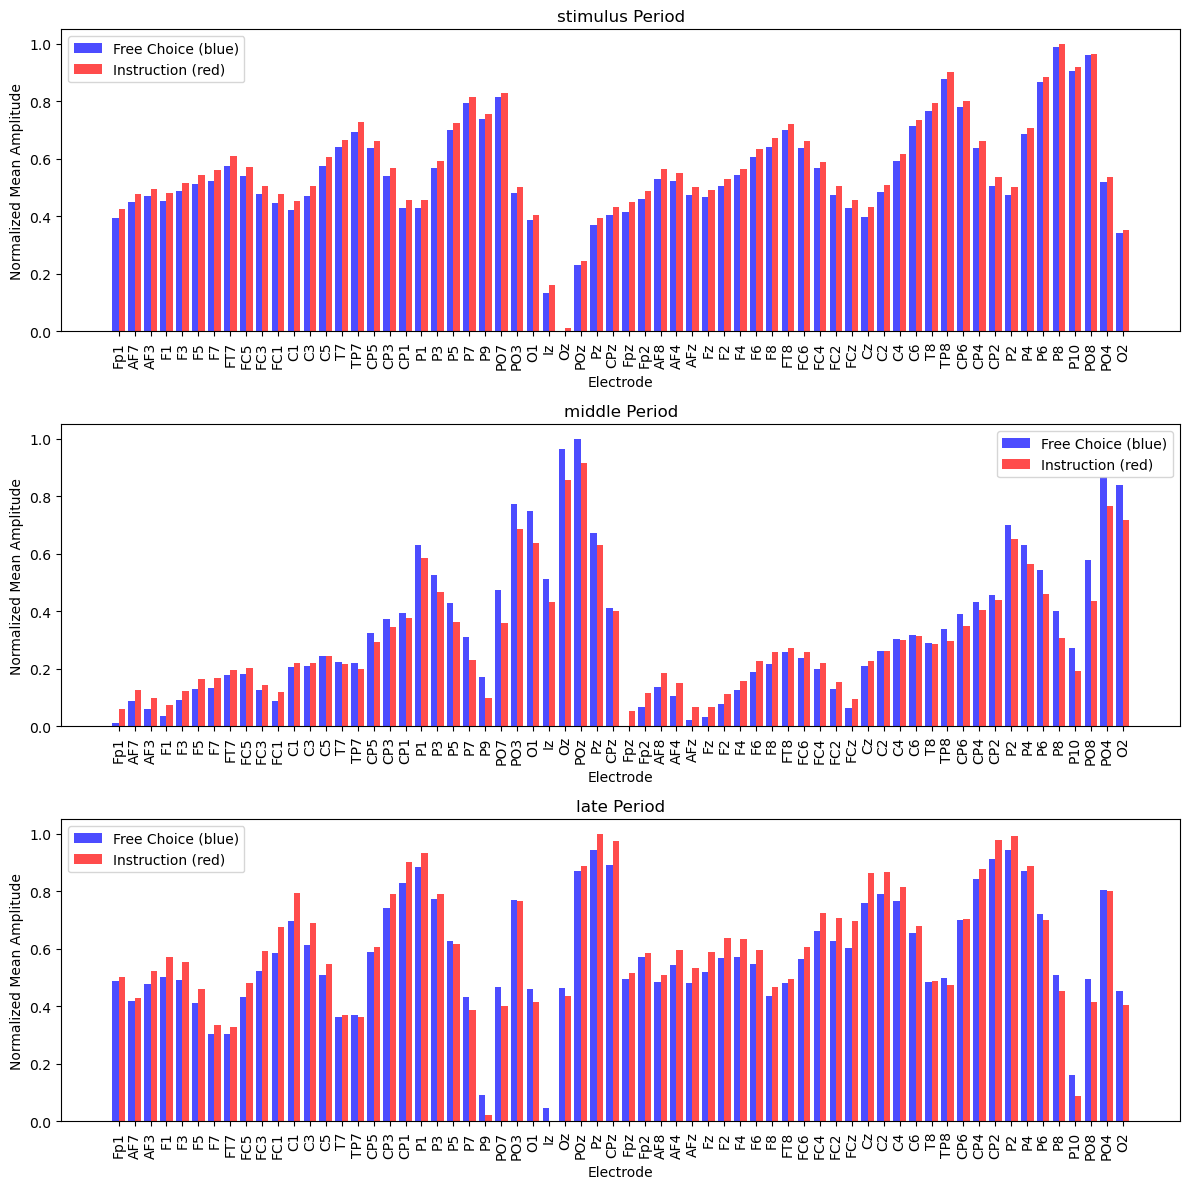

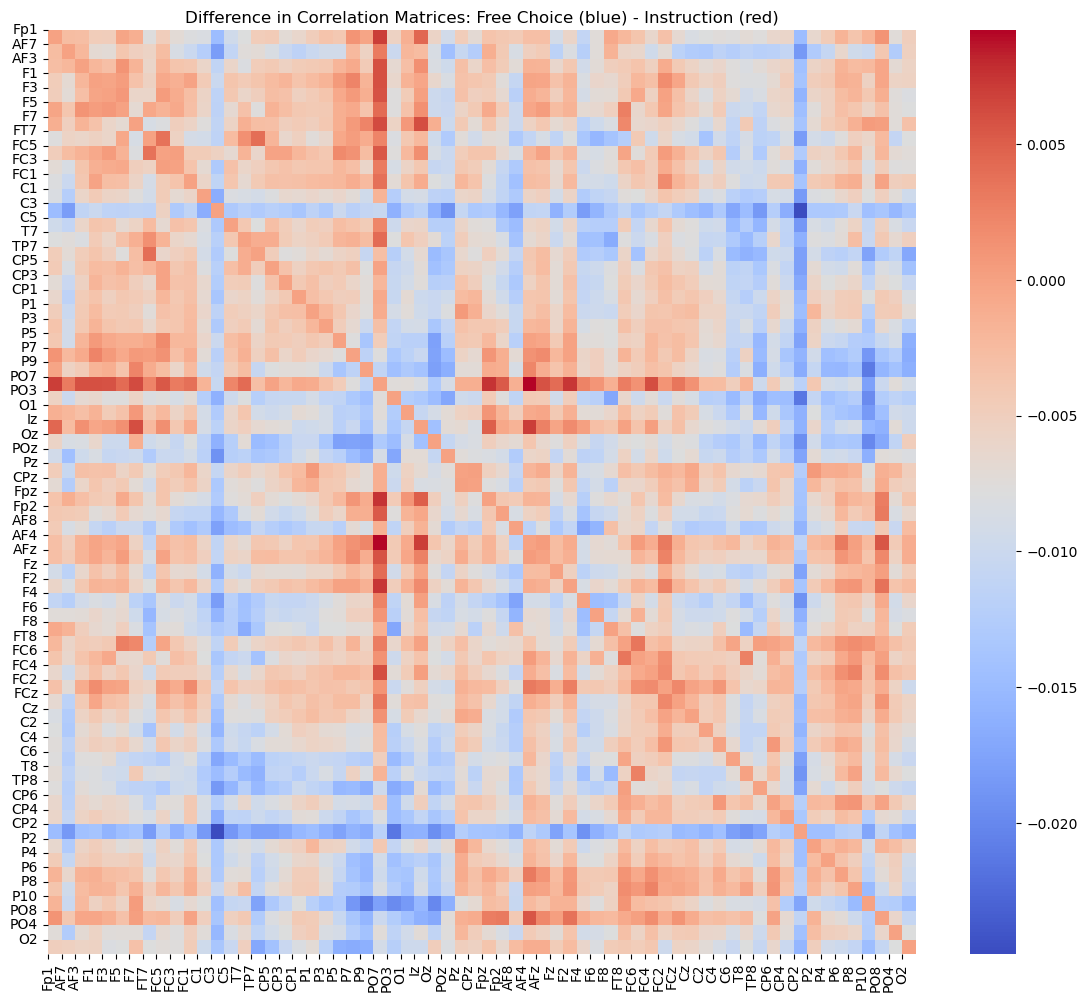

In [ ]:
free_choice_mask = cues == 4  # '+' = 4
instruction_mask = (true_labels == 1) | (true_labels == 2)  # 'R' = 1, 'L' = 2
legend_labels = ["Free Choice (blue)", "Instruction (red)"]

avg_free_choice = np.nanmean(trials_dataset[:, free_choice_mask, :], axis=1)
avg_instruction = np.nanmean(trials_dataset[:, instruction_mask, :], axis=1)
mean_electrode_by_period(avg_free_choice, avg_instruction, legend_labels, default_periods)
plot_electrode_corr_difference(trials_dataset, free_choice_mask, instruction_mask, legend_labels)

In [ ]:
print_electrode_differences(avg_free_choice, avg_instruction, electrodes_names, label1="Free Choice", label2="Instruction")
analyze_category_differences(trials_dataset, free_choice_mask, instruction_mask, periods=periods, category_names=("Free Choice", "Instruction"))


Electrodes with minimal difference between Free Choice and Instruction (All periods):
T8: 0.0018
P6: 0.0093
PO4: 0.0128
TP8: 0.0252
P5: 0.0426
PO3: 0.0657
Fp2: 0.0685

Electrodes with maximal difference between Free Choice and Instruction (All periods):
C1: 0.6672
Cz: 0.6594
FCz: 0.5932
FC1: 0.5595
CPz: 0.5582
FC2: 0.5443
C3: 0.5323

stimulus Period:
  Right Avg: -0.7483, Left Avg: -0.6636
  Difference: -0.0847
  Top 5 Electrodes with Lowest p-values:
    Electrode FT7: p-value = 4.2757e-01
    Electrode F7: p-value = 4.7849e-01
    Electrode CP1: p-value = 5.7411e-01
    Electrode C3: p-value = 5.7836e-01
    Electrode FC5: p-value = 5.8480e-01

middle Period:
  Right Avg: -0.7229, Left Avg: -0.8119
  Difference: 0.0890
  Top 5 Electrodes with Lowest p-values:
    Electrode Fp1: p-value = 2.4576e-01
    Electrode Fpz: p-value = 3.0455e-01
    Electrode AF8: p-value = 3.0930e-01
    Electrode F7: p-value = 3.1937e-01
    Electrode F5: p-value = 3.3080e-01

late Period:
  Right Avg: 5.

### Plot time-varying correlation between two selected electrodes

In [ ]:
def plot_time_varying_correlation(data, electrode1, electrode2, window_size=2):
    """
    Plot the correlation between two electrodes over time (using a sliding window).
    """
    # Find indices of electrodes
    electrode1_idx = np.where(electrodes_names == electrode1)[0][0]
    electrode2_idx = np.where(electrodes_names == electrode2)[0][0]
    
    # Calculate correlations with window
    correlations = []
    time_points = range(data.shape[2] - window_size + 1)
    
    for t in time_points:
        seg1 = data[electrode1_idx, :, t:t+window_size].flatten()
        seg2 = data[electrode2_idx, :, t:t+window_size].flatten()
        # Remove NaN values that might cause issues
        valid_idx = ~(np.isnan(seg1) | np.isnan(seg2))
        if np.sum(valid_idx) > 10:  # Only calculate if enough valid data points
            corr, _ = pearsonr(seg1[valid_idx], seg2[valid_idx])
            correlations.append(corr)
        else:
            correlations.append(np.nan)
    
    # Create plotly figure
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(time_points),
        y=correlations,
        mode='lines',
        name=f'{electrode1} vs {electrode2}'
    ))
    
    fig.update_layout(
        title=f"Time-varying Correlation: {electrode1} vs {electrode2}",
        xaxis_title="Time (sample)",
        yaxis_title="Correlation",
        height=500,
        width=800
    )
    
    return fig

@interact(
    electrode1=widgets.Dropdown(
        options=electrodes_names,
        value='P9',
        description='Electrode 1:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    ),
    electrode2=widgets.Dropdown(
        options=electrodes_names,
        value='P10',
        description='Electrode 2:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    ),
    window_size=widgets.IntSlider(
        min=1, max=10, step=1, value=2,
        description='Window size:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
)
def update_correlation_plot(electrode1, electrode2, window_size):
    fig = plot_time_varying_correlation(trials_dataset, electrode1, electrode2, window_size)
    return fig

interactive(children=(Dropdown(description='Electrode 1:', index=23, layout=Layout(width='200px'), options=('F…

### Variance analysis: find electrodes with lowest variance (least active)


In [ ]:
variance_activity = np.nanvar(trials_dataset, axis=(1,2))
sorted_variance_indices = np.argsort(variance_activity)
print("Electrodes sorted by variance (lowest first):")
for i in range(10):
    idx = sorted_variance_indices[i]
    print(f"{electrodes_names[idx]}: {variance_activity[idx]:.4f}")

Electrodes sorted by variance (lowest first):
P10: 226.3971
T7: 230.3271
TP7: 230.8308
C5: 234.5961
TP8: 239.1030
C6: 240.2946
P8: 244.3639
CP5: 246.1034
P9: 254.4530
FT8: 256.6855


In [ ]:
raise SystemExit("End of analysis")

SystemExit: End of analysis

## Cluster Analysis

Select trials for analysis

In [ ]:
# params

label_map = {1: 'R', 2: 'L', 3: 'N', 4: '+'}

# # Option 1: Use Right vs Left trials
# right_trials = np.where(true_labels == 1)[0]
# left_trials = np.where(true_labels == 2)[0]
# selected_trials = np.concatenate([right_trials, left_trials])
# print(f"Selected {len(selected_trials)} Right/Left trials")

# Option 2: Use Congruent vs Incongruent trials
# congruent_mask = (primes == cues) & ((primes == 1) | (primes == 2))
# incongruent_mask = (primes != cues) & ((primes == 1) | (primes == 2)) & ((cues == 1) | (cues == 2))
# congruent_trials = np.where(congruent_mask)[0]
# incongruent_trials = np.where(incongruent_mask)[0]
# selected_trials = np.concatenate([congruent_trials, incongruent_trials])
# print(f"Selected {len(selected_trials)} Congruent/Incongruent trials")

# Option 3: Use Free Choice vs Instruction trials
free_choice_mask = (cues == 4)
instruction_mask = ((cues == 1) | (cues == 2))
free_choice_trials = np.where(free_choice_mask)[0]
instruction_trials = np.where(instruction_mask)[0]
selected_trials = np.concatenate([free_choice_trials, instruction_trials])
print(f"Selected {len(selected_trials)} Free Choice/Instruction trials")

# # Subsample if too many trials
# max_trials = 5000
# if len(selected_trials) > max_trials:
#     selected_trials = np.random.choice(selected_trials, max_trials, replace=False)
#     print(f"Subsampled to {len(selected_trials)} trials")

Selected 52159 Free Choice/Instruction trials


Preprocess selected trials.
Two options:
1. Average across time to get one vector per trial (shape: (trials, electrodes))
2. Flatten time dimension for each trial (shape: (trials, electrodes * time))

In [ ]:
def preprocess_data(trials_dataset, selected_trials=None, time_window=slice(35, 85)):
    """Preprocess the EEG data for clustering."""
    # Select trials if specified, otherwise use all
    if selected_trials is None:
        selected_trials = np.arange(trials_dataset.shape[1])

    data = trials_dataset[:, selected_trials, time_window]
    print(f"Selected data shape: {data.shape}")

    # # Option 1: Average across time to get one vector per trial
    # trial_vectors = np.nanmean(data, axis=2)  # shape: (electrodes, trials)
    # trial_vectors = trial_vectors.T  # shape: (trials, electrodes)

    # Option 2: Flatten time dimension for each trial (preserves temporal patterns)
    trial_vectors = np.reshape(data, (data.shape[0], data.shape[1], -1))
    trial_vectors = np.transpose(trial_vectors, (1, 0, 2))
    trial_vectors = np.reshape(trial_vectors, (trial_vectors.shape[0], -1))

    trial_vectors = np.nan_to_num(trial_vectors, nan=0)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(trial_vectors)

    return scaled_data, selected_trials

time_window = slice(*periods["middle"])
scaled_data, selected_trials = preprocess_data(trials_dataset, selected_trials, time_window)

Selected data shape: (64, 52159, 15)


### Reduce dimensionality and apply clustering

In [ ]:
def reduce_dimensions(data, n_components=2, method="pca"):
    """Reduce dimensions for visualization."""
    if method.lower() == "pca":
        reducer = PCA(n_components=n_components)
    elif method.lower() == "tsne":
        reducer = TSNE(n_components=n_components, random_state=42)

    reduced_data = reducer.fit_transform(data)
    return reduced_data


def apply_kmeans_clustering(data, n_clusters=3):
    """Apply K-means clustering."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data)

    silhouette = silhouette_score(data, clusters)
    db_score = davies_bouldin_score(data, clusters)

    print(f"K-means clustering with {n_clusters} clusters:")
    print(f"  Silhouette score: {silhouette:.4f}")
    print(f"  Davies-Bouldin score: {db_score:.4f}")

    return clusters, kmeans.cluster_centers_


def apply_hierarchical_clustering(data, n_clusters=3):
    """Apply hierarchical clustering."""
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = hierarchical.fit_predict(data)

    silhouette = silhouette_score(data, clusters)
    db_score = davies_bouldin_score(data, clusters)

    print(f"Hierarchical clustering with {n_clusters} clusters:")
    print(f"  Silhouette score: {silhouette:.4f}")
    print(f"  Davies-Bouldin score: {db_score:.4f}")

    return clusters


def apply_dbscan_clustering(data, eps=0.5, min_samples=5):
    """Apply DBSCAN clustering."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)

    # Check for noise points
    n_noise = np.sum(clusters == -1)
    n_clusters = len(np.unique(clusters)) - (1 if -1 in clusters else 0)

    print(f"DBSCAN clustering with eps={eps}, min_samples={min_samples}:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Number of noise points: {n_noise} ({n_noise/len(clusters)*100:.1f}%)")

    if n_clusters > 1:
        # Remove noise points for metrics calculation
        non_noise_indices = clusters != -1
        if np.sum(non_noise_indices) > 1:
            silhouette = silhouette_score(data[non_noise_indices], clusters[non_noise_indices])
            db_score = davies_bouldin_score(data[non_noise_indices], clusters[non_noise_indices])
            print(f"  Silhouette score: {silhouette:.4f}")
            print(f"  Davies-Bouldin score: {db_score:.4f}")

    return clusters


def evaluate_clusters_vs_labels(clusters, true_labels, selected_trials, label_map):
    """Evaluate clustering results against known labels."""
    original_labels = true_labels[selected_trials]

    unique_clusters = np.unique(clusters)
    for cluster_id in unique_clusters:
        cluster_indices = np.where(clusters == cluster_id)[0]

        if cluster_id == -1:
            print(f"Noise points: {len(cluster_indices)}")
        else:
            print(f"Cluster {cluster_id+1}: {len(cluster_indices)} trials")

        for label in np.unique(original_labels):
            label_count = np.sum(original_labels[cluster_indices] == label)
            label_pct = label_count / len(cluster_indices) * 100 if len(cluster_indices) > 0 else 0
            print(f"  {label_map.get(label, label)}: {label_count} ({label_pct:.1f}%)")

In [ ]:
reduced_data_pca = reduce_dimensions(scaled_data, method='pca')
reduced_data_tsne = reduce_dimensions(scaled_data, method='tsne')

# plot the reduced data
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of EEG Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()

In [ ]:
n_clusters = 5
# kmeans_clusters, cluster_centers = apply_kmeans_clustering(scaled_data, n_clusters)
hierarchical_clusters = apply_hierarchical_clustering(scaled_data, n_clusters)

# nn = NearestNeighbors(n_neighbors=10)
# nn.fit(scaled_data)
# distances, _ = nn.kneighbors(scaled_data)
# eps = np.percentile(distances[:, -1], 90)  # Use 90th percentile as eps
# print(f"Estimated DBSCAN eps: {eps:.4f}")
# dbscan_clusters = apply_dbscan_clustering(scaled_data, eps=eps, min_samples=10)

# print("\nK-means clusters vs labels:")
# evaluate_clusters_vs_labels(kmeans_clusters, true_labels, selected_trials, label_map)

print("\nHierarchical clusters vs labels:")
evaluate_clusters_vs_labels(hierarchical_clusters, true_labels, selected_trials, label_map)

# print("\nDBSCAN clusters vs labels:")
# evaluate_clusters_vs_labels(dbscan_clusters, true_labels, selected_trials, label_map)

### Evaluate clusters vs known labels and determine best clustering approach

In [ ]:
def analyze_cluster_differences(trials_dataset, clusters, selected_trials, electrodes_names, time_window=slice(35, 80)):
    """Analyze differences between clusters in terms of EEG patterns."""
    unique_clusters = np.unique(clusters)

    if -1 in unique_clusters:
        unique_clusters = unique_clusters[unique_clusters != -1]

    data = trials_dataset[:, selected_trials, time_window]
    cluster_avg_activities = []
    for cluster_id in unique_clusters:
        cluster_indices = np.where(clusters == cluster_id)[0]
        original_indices = selected_trials[cluster_indices]
        cluster_data = trials_dataset[:, original_indices, time_window]
        cluster_avg = np.nanmean(cluster_data, axis=1)
        cluster_avg_activities.append(cluster_avg)

    if len(unique_clusters) > 1:
        avg_activities = [np.nanmean(act, axis=1) for act in cluster_avg_activities]
        diff_electrodes = []
        for i in range(len(unique_clusters)):
            for j in range(i + 1, len(unique_clusters)):
                cluster_i = unique_clusters[i]
                cluster_j = unique_clusters[j]
                diff = np.abs(avg_activities[i] - avg_activities[j])
                top_indices = np.argsort(-diff)[:5]
                diff_values = diff[top_indices]
                diff_electrodes.append((cluster_i, cluster_j, top_indices, diff_values))

        print("\nDistinguishing electrodes between clusters:")
        for cluster_i, cluster_j, electrodes, values in diff_electrodes:
            print(f"Between Cluster {cluster_i+1} and Cluster {cluster_j+1}:")
            for k, (electrode, value) in enumerate(zip(electrodes, values)):
                print(f"  Electrode {electrodes_names[electrode]}: Difference = {value:.4f}")


analyze_cluster_differences(trials_dataset, kmeans_clusters, selected_trials, electrodes_names, time_window)

# Compare silhouette scores
sil_kmeans = silhouette_score(scaled_data, kmeans_clusters)
sil_hierarchical = silhouette_score(scaled_data, hierarchical_clusters)

dbscan_unique = np.unique(dbscan_clusters)
if len(dbscan_unique) > 1 and -1 not in dbscan_unique:
    sil_dbscan = silhouette_score(scaled_data, dbscan_clusters)
elif len(dbscan_unique) > 1:
    non_noise = dbscan_clusters != -1
    non_noise_labels = dbscan_clusters[non_noise]
    if np.sum(non_noise) > 1 and len(np.unique(non_noise_labels)) > 1:
        sil_dbscan = silhouette_score(scaled_data[non_noise], non_noise_labels)
    else:
        print("Warning: DBSCAN found only one cluster (after removing noise). Silhouette score not defined.")
        sil_dbscan = -1
else:
    print("Warning: DBSCAN found only one cluster or all noise. Silhouette score not defined.")
    sil_dbscan = -1

print(f"K-means silhouette score: {sil_kmeans:.4f}")
print(f"Hierarchical silhouette score: {sil_hierarchical:.4f}")
print(f"DBSCAN silhouette score: {sil_dbscan:.4f}")

# Find best method
best_score = max(sil_kmeans, sil_hierarchical, sil_dbscan)
if best_score == sil_kmeans:
    best_method = "K-means"
    best_clusters = kmeans_clusters
elif best_score == sil_hierarchical:
    best_method = "Hierarchical clustering"
    best_clusters = hierarchical_clusters
else:
    best_method = "DBSCAN"
    best_clusters = dbscan_clusters

print(f"\nBest clustering method: {best_method} with silhouette score {best_score:.4f}")

### Compare clustering results with true labels

In [ ]:
right_indices = np.where(true_labels[selected_trials] == 1)[0]
left_indices = np.where(true_labels[selected_trials] == 2)[0]

best_unique_clusters = np.unique(best_clusters)
if -1 in best_unique_clusters:
    best_unique_clusters = best_unique_clusters[best_unique_clusters != -1]

cluster_accuracies = []
for cluster_id in best_unique_clusters:
    cluster_indices = np.where(best_clusters == cluster_id)[0]
    right_count = np.sum(np.isin(cluster_indices, right_indices))
    left_count = np.sum(np.isin(cluster_indices, left_indices))
    
    if right_count > left_count:
        majority_label = 'R'
        majority_count = right_count
        accuracy = right_count / (right_count + left_count)
    else:
        majority_label = 'L'
        majority_count = left_count
        accuracy = left_count / (right_count + left_count)
    
    print(f"Cluster {cluster_id+1}: Majority label = {majority_label}, Accuracy = {accuracy:.2f}")
    print(f"  Right: {right_count}, Left: {left_count}")
    
    cluster_accuracies.append(accuracy)

avg_accuracy = np.mean(cluster_accuracies)
print(f"\nAverage cluster accuracy: {avg_accuracy:.4f}")